## Desafio de Projeto
### Projeto de Transfer Learning em Python
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.
O objetivo é permitir a correta identificação de componentes de uma imagem através do aprendizado de máquina.
Para esse estudo serão utilizadas imagens de cães e gatos disponibilizadas pela própria DIO.

#### Atividade extra
Estou desenvolvendo paralelamente um estudo utilizando técnicas de Machine Learning sobre as eleições 2022 (espero ter terminado até a avaliação desse trabalho 😏)
https://github.com/GenildoPraca/dio-ciencia-de-dados/tree/main/machine-learning/estudo-eleicoes-2022/

O modelo para o desenvolvimento desse trabalho é o projeto
Transfer Learning com o Dataset do MNIST que pode ser encontrado em:

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb 

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

#Inserida a biblioteca abaixo para permitir descompactar o arquivo diretamente
import zipfile

Nesse ponto o modelo foi modificado para permitir acesso às pastas de meu Google Drive pessoal onde se encontra o arquivo zipado disponibilizado

In [ ]:
#Conectando ao google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Realizando a extração do arquivo zip.
path = '/content/drive/MyDrive/kagglecatsanddogs_5340.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

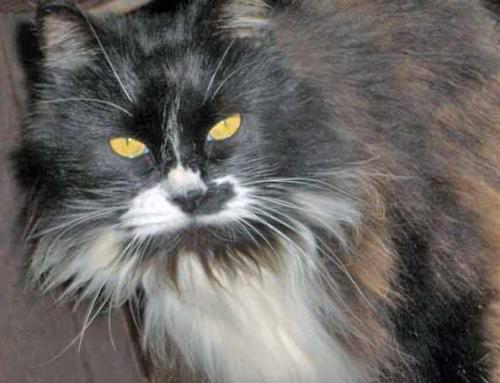

In [3]:
#Visualizando uma imagem do arquivo extraído para confirmar o sucesso da operação
image.image_utils.load_img('/content/PetImages/Cat/40.jpg')

In [11]:
#Utiliza os nomes dos subdiretórios presentes na pasta para nomear as categorias.
#Esse objeto será utilizado para percorrer os arquivos
root = '/content/PetImages/'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/content/PetImages/Dog', '/content/PetImages/Cat']


In [12]:
# Cria uma função para carregar a imagem  e inseri-la em um vetor
def get_image(path):
    img = image.image_utils.load_img(path, target_size=(224, 224))
    x = image.image_utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

O trecho abaixo, responsável por carregar as imagens em uma matriz, foi limitado a 500 arquivos de cada diretório devido ao consumo excessivo de processamento caso se opta-se por utilizar todas as 25.004 imagens disponíveis. Além disso identifiquei que algumas das imagens causam um erro e seria necessário um tratamento, porém a falha não ocorre no intervalo até 1050 imagens.

In [13]:
data = []
for c, category in enumerate(categories):
  images = [os.path.join(dp, f) for dp, dn, filenames 
            in os.walk(category) for f in filenames 
            if os.path.splitext(f)[1].lower() in ['.jpg']]
  i = 0
  for img_path in images:
    img, x = get_image(img_path)
    data.append({'x':np.array(x[0]), 'y':c})

    i += 1
    if (i > 500):
      break #limita a 500 arquivos por diretório

# count the number of classes
num_classes = len(categories)

In [14]:
#Embaralha as imagens de cães e gatos carregadas no processo acima
random.shuffle(data)

Cria matrizes de treinamento / validação e testes com partes da base original - (70%, 15%, 15%)

In [15]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Nesse ponto as imagens na base de treinamento são categorizadas (0 - Dog, 1 - Cat)

In [16]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


Pre-processamento dos dados para garantir que os tipo é um float32 e normalizado entre 0 e 1.

In [17]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(151, 2)


Sumário dos dados

In [18]:
# summary
print("Imagens carregadas %d de %d categorias"%(len(data), num_classes))
print("treinamento / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Formato dados treinamento: ", x_train.shape)
print("Formato etiquetas(labels) de treinamento: ", y_train.shape)

Imagens carregadas 1002 de 2 categorias
treinamento / validação / teste: 701, 150, 151
Formato dados treinamento:  (701, 224, 224, 3)
Formato etiquetas(labels) de treinamento:  (701, 2)


Exemplo das imagens que compôem a base

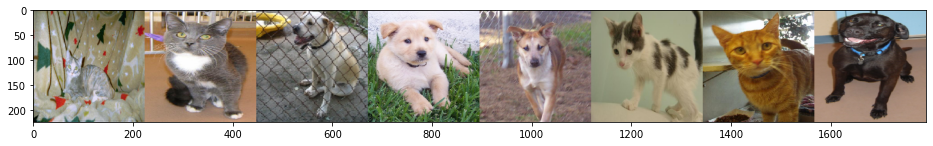

In [19]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.image_utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiro treinamento da rede neural antes de executar o transfer learning.
Nesse ponto foram seguidos os parâmetros indicados no projeto modelo.

In [20]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

Criação da rede neural. Com a redução de imagens trabalhadas foi possível manter as configurações do projeto original.
Caso se aumente o número de arquivos pode ser necessário reduzir o parâmetro 'epochs' para permitir um tempo viável de processamento.

In [21]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 50s 7s/step - loss: 0.7146 - accuracy: 0.4964 - val_loss: 0.6971 - val_accuracy: 0.4800
Epoch 2/10
6/6 [==============================] - 44s 7s/step - loss: 0.6933 - accuracy: 0.5221 - val_loss: 0.6889 - val_accuracy: 0.5200
Epoch 3/10
6/6 [==============================] - 48s 8s/step - loss: 0.6904 - accuracy: 0.5178 - val_loss: 0.6840 - val_accuracy: 0.5867
Epoch 4/10
6/6 [==============================] - 50s 9s/step - loss: 0.6801 - accuracy: 0.5820 - val_loss: 0.6688 - val_accuracy: 0.6133
Epoch 5/10
6/6 [==============================] - 55s 9s/step - loss: 0.6486 - accuracy: 0.6248 - val_loss: 0.6328 - val_accuracy: 0.5867
Epoch 6/10
6/6 [==============================] - 49s 8s/step - loss: 0.6502 - accuracy: 0.6334 - val_loss: 0.6308 - val_accuracy: 0.6200
Epoch 7/10
6/6 [==============================] - 44s 7s/step - loss: 0.6242 - accuracy: 0.6419 - val_loss: 0.6318 - val_accuracy: 0.6200
Epoch 8/10
6/6 [==================

Exibe os gráficos das métricas **validation loss** e **validation accuracy**

validation loss - indica o quanto o modelo se ajusta a novos dados
validation accuracy - indica a precisão (acurácia) do modelo

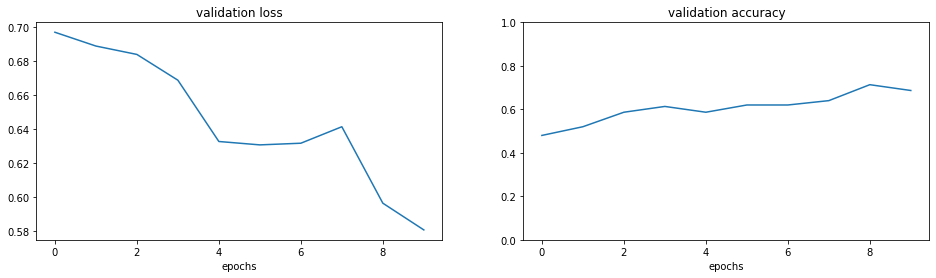

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Avaliação do nosso modelo nos dados de teste:

In [23]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.615656852722168
Test accuracy: 0.6423841118812561


Seguindo o projeto base para esse estudo será utilizado o modelo neural já treinado no ImageNet

In [24]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [25]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [26]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Treina o novo modelo

In [27]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 440s 75s/step - loss: 0.9754 - accuracy: 0.5093 - val_loss: 0.6029 - val_accuracy: 0.6333
Epoch 2/10
6/6 [==============================] - 436s 74s/step - loss: 0.6398 - accuracy: 0.6234 - val_loss: 0.5802 - val_accuracy: 0.5933
Epoch 3/10
6/6 [==============================] - 439s 75s/step - loss: 0.5554 - accuracy: 0.6733 - val_loss: 0.5371 - val_accuracy: 0.6800
Epoch 4/10
6/6 [==============================] - 438s 75s/step - loss: 0.4786 - accuracy: 0.7775 - val_loss: 0.4407 - val_accuracy: 0.8600
Epoch 5/10
6/6 [==============================] - 433s 74s/step - loss: 0.4383 - accuracy: 0.8260 - val_loss: 0.4068 - val_accuracy: 0.8733
Epoch 6/10
6/6 [==============================] - 434s 73s/step - loss: 0.4007 - accuracy: 0.8545 - val_loss: 0.3934 - val_accuracy: 0.8333
Epoch 7/10
6/6 [==============================] - 433s 74s/step - loss: 0.3732 - accuracy: 0.8645 - val_loss: 0.3694 - val_accuracy: 0.8933
Epoch 8/10
6/6 [====

Avaliamos as métricas do novo modelo graficamente, assim como fizemos com o modelo anterior.

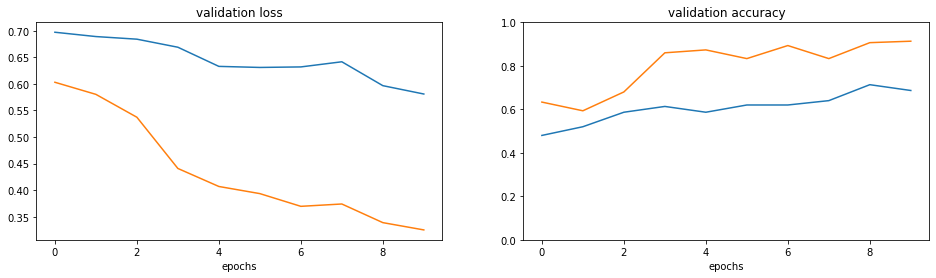

In [28]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [29]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3194638788700104
Test accuracy: 0.8940397500991821


Podemos observar que houve uma melhora nas métricas:

Test loss: 0.615656852722168 -> 0.3194638788700104

Test accuracy: 0.6423841118812561 -> 0.8940397500991821

Agora vem a parte divertida, testar se o modelo consegue prever corretamente em novas imagens.
Ambas imagens testadas não compôem o pacote original e foram previamente carregadas para meu Google Drive pessoal.

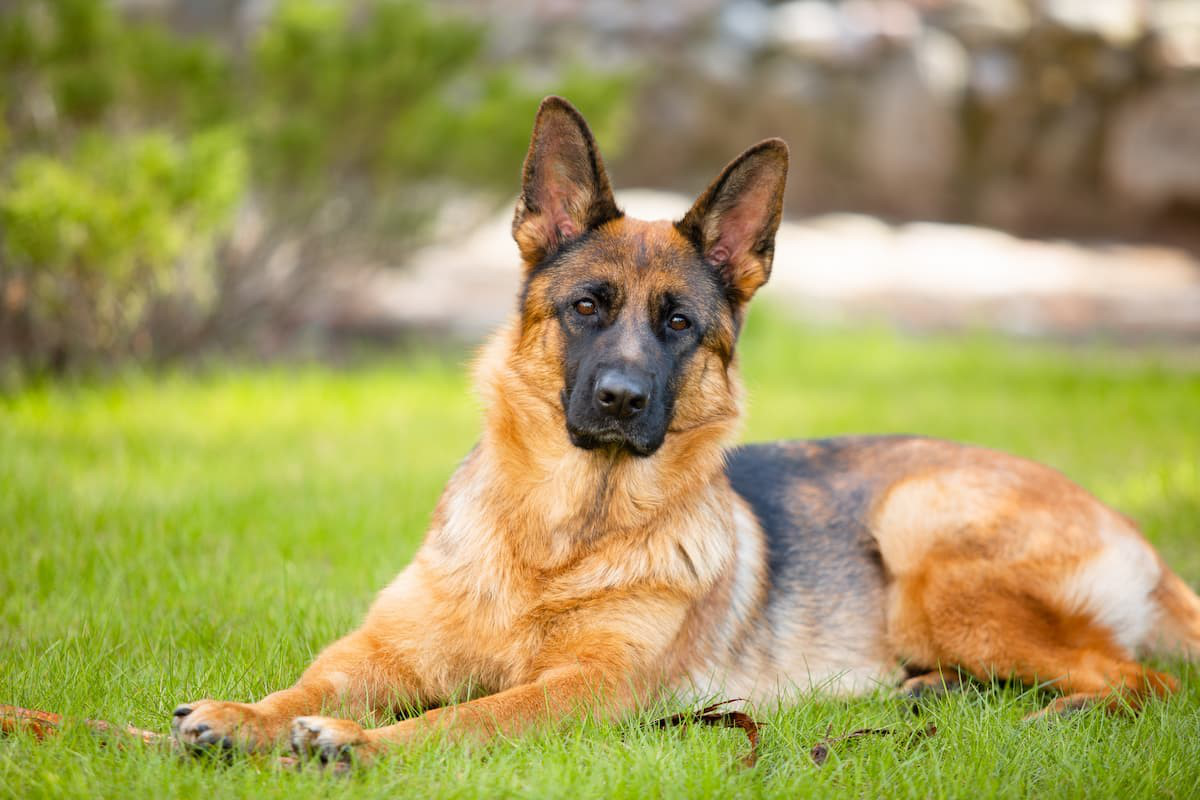

In [36]:
image.image_utils.load_img('/content/drive/MyDrive/pastor_alemao.png')

In [37]:
img, x = get_image('/content/drive/MyDrive/pastor_alemao.png')
probabilities = model_new.predict([x])

if (np.argmax(probabilities) == 0):
  print("É a imagem de um cachorro")
else:
  print("É a imagem de um gato")

1/1 [==============================] - 1s 578ms/step
É a imagem de um cachorro


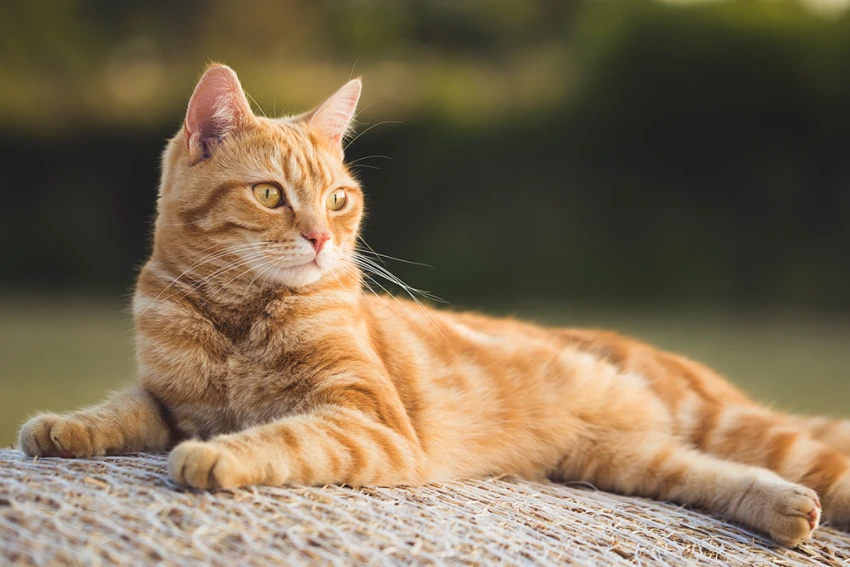

In [38]:
image.image_utils.load_img('/content/drive/MyDrive/gato_amarelo.png')

In [40]:
img, x = get_image('/content/drive/MyDrive/gato_amarelo.png')
probabilities = model_new.predict([x])

if (np.argmax(probabilities) == 0):
  print("É a imagem de um cachorro")
else:
  print("É a imagem de um gato")

1/1 [==============================] - 1s 584ms/step
É a imagem de um gato
